In [67]:
# ================================================
# 1. Importar librerías
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración estética
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style="whitegrid")

In [68]:
# ================================================
# 2. Cargar datos (funciona CSV o XLSX)
# ================================================
# Cambia el archivo según el formato que tengas
file = "citybike_lima.csv"   # o "citybike_lima.xlsx"

if file.endswith(".csv"):
    df = pd.read_csv(file)
elif file.endswith(".xlsx"):
    df = pd.read_excel(file)

print("Dimensiones del dataset:", df.shape)
df.head()


Dimensiones del dataset: (3238, 17)


,scrape_timestamp,station_id,station_name,lat,lon,capacity,free_bikes,empty_slots,day_of_week,periodo_dia,weather_main,weather_desc,temp_C,wind_speed,clima_miraflores,temp_miraflores,in_miraflores
0,2025-10-01T11:34:22.005486-05:00,008a35afc6b4060be57b48bf90bec44c,18027 Ov. Julio Ramón Riveyro - Av. Pardo,-12.119013,-77.039928,14,8,6,Wednesday,mañana,NaN,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True
1,2025-10-01T11:34:22.005486-05:00,03367da30caea302b11c838d8b98df55,18009 Ca. Luis Schereiber Cdra. 2 (C.C. Aurora),-12.122125,-77.011506,16,8,8,Wednesday,mañana,NaN,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,False
2,2025-10-01T11:34:22.005486-05:00,06dd87a8b87232577015b1c9a4ba08ed,18024 Ov. Bolognesi - Ca. Madrid,-12.123368,-77.035637,14,3,11,Wednesday,mañana,NaN,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True
3,2025-10-01T11:34:22.005486-05:00,0927eccbf04e2aadd179595c55c52bbe,18047 Malecón Cisneros - Ca. Trípoli,-12.125037,-77.037307,16,9,7,Wednesday,mañana,NaN,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True
4,2025-10-01T11:34:22.005486-05:00,0ac132eb1a147b7b23a753185cbebd1d,18026 Malecón de la Marina - Parque Grau,-12.118497,-77.045048,20,11,9,Wednesday,mañana,NaN,NaN,19.0,NaN,Clima: pronóstico del tiempo,19.0,True


In [69]:
# ================================================
# 3. Revisión inicial
# ================================================
print("\nTipos de datos:")
print(df.dtypes)

print("\nNulos por columna:")
print(df.isnull().sum())

print("\nDuplicados:", df.duplicated().sum())




Tipos de datos:
scrape_timestamp     object
station_id           object
station_name         object
lat                 float64
lon                 float64
capacity              int64
free_bikes            int64
empty_slots           int64
day_of_week          object
periodo_dia          object
weather_main        float64
weather_desc        float64
temp_C              float64
wind_speed          float64
clima_miraflores     object
temp_miraflores     float64
in_miraflores          bool
dtype: object

Nulos por columna:
scrape_timestamp       0
station_id             0
station_name           0
lat                    0
lon                    0
capacity               0
free_bikes             0
empty_slots            0
day_of_week            0
periodo_dia            0
weather_main        3238
weather_desc        3238
temp_C                 0
wind_speed          3238
clima_miraflores       0
temp_miraflores        0
in_miraflores          0
dtype: int64

Duplicados: 0


In [70]:
# Renombrar variables clave
df = df.rename(columns={
    "scrape_timestamp": "timestamp",
    "station_id": "id_estacion",
    "station_name": "nombre_estacion",
    "lat": "latitud",
    "lon": "longitud",
    "capacity": "capacidad",
    "free_bikes": "bicis_libres",
    "empty_slots": "espacios_vacios",
    "day_of_week": "dia_semana",
    "weather_main": "clima_general",
    "weather_desc": "clima_detalle",
    "temp_C": "temp_c",
    "wind_speed": "vel_viento",
    "clima_miraflores": "clima_miraflores",
    "temp_miraflores": "temp_miraflores",
    "in_miraflores": "en_miraflores"
})

# No eliminar filas si clima está vacío → solo no usar esas columnas
df = df.dropna(subset=["bicis_libres", "espacios_vacios", "capacidad"])
df["dia_semana"] = df["dia_semana"].astype(str).str.strip()

# Crear variable de ocupación
df["ocupacion"] = df["bicis_libres"] / df["capacidad"]
df["ocupacion"] = df["ocupacion"].clip(0, 1)
df["ocupacion"] = df["ocupacion"].round(2)

In [71]:
# Timestamp
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"])
else:
    raise KeyError("⚠️ No se encontró la columna de timestamp")

df["hora"] = df["timestamp"].dt.hour
df["fecha"] = df["timestamp"].dt.date

# Si no hay día de semana explícito, derivarlo
if df["dia_semana"].nunique() <= 1:
    df["dia_semana"] = df["timestamp"].dt.day_name(locale="es_ES")
    df["dia_semana"] = df["dia_semana"].str.slice(0,3)  # Lun, Mar, etc.
    dias_orden = ["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"]
    df["dia_semana"] = pd.Categorical(df["dia_semana"], categories=dias_orden, ordered=True)


In [72]:
# ================================================
# 7. Estadísticas descriptivas
# ================================================
print("\nResumen estadístico:")
print(df.describe(include="all"))



Resumen estadístico:
                                  timestamp                       id_estacion  \
count                                  3238                              3238   
unique                                  NaN                                51   
top                                     NaN  008a35afc6b4060be57b48bf90bec44c   
freq                                    NaN                                64   
mean    2025-10-02 04:09:15.326971648-05:00                               NaN   
min        2025-10-01 11:34:22.005486-05:00                               NaN   
25%     2025-10-01 18:13:34.933168128-05:00                               NaN   
50%     2025-10-02 04:15:59.350793984-05:00                               NaN   
75%     2025-10-02 12:36:19.734091008-05:00                               NaN   
max        2025-10-02 22:45:50.333227-05:00                               NaN   
std                                     NaN                               NaN   

     

In [78]:
# ================================================
# 8. Análisis por estación
# ================================================
station_summary = df.groupby("id_estacion").agg(
    nombre_estacion=("nombre_estacion", "first"),
    obs=("id_estacion","count"),
    bicis_promedio=("bicis_libres","mean"),
    capacidad_promedio=("capacidad","mean"),
    ocupacion_promedio=("ocupacion","mean"),
    pct_vacia=("bicis_libres", lambda x: (x==0).mean()*100),
    pct_llena=("espacios_vacios", lambda x: (x==0).mean()*100),
    hora_pico=("hora", lambda x: x.value_counts().idxmax())
).reset_index()

station_summary.sort_values("pct_vacia", ascending=False).head(10)
station_summary.sort_values("pct_llena", ascending=False).head(10)
station_summary.sort_values("ocupacion_promedio").head(15)

,id_estacion,nombre_estacion,obs,bicis_promedio,capacidad_promedio,ocupacion_promedio,pct_vacia,pct_llena,hora_pico
17,6369e20f974a82f599ac39793a9ceeef,27042 Av. P. Carriquiry - Av. Ricardo Angulo,38,0.000000,16.0,0.000000,100.0000,0.0,11
50,eff5bc44fad7421819820f56aa6ded68,18012 Ca. Ignacio La Puente - Av. Benavides,64,3.578125,20.0,0.178906,0.0000,0.0,11
21,696787ac674aad03dc56a790f1f9e6ed,18033 Ca. Scipión Llona Cdra.3,64,3.218750,16.0,0.199687,1.5625,0.0,11
39,b01138adb0102e1f6862bb8ba54b9721,18014 Ca. Ramon Ribeyro - Av. Benavides,64,5.109375,24.0,0.213906,0.0000,0.0,11
27,758f33f3320ac4a7aca286cf7e57bef4,18038 Ca. Gral. Borgoño - Ca. Ayacucho,64,4.281250,20.0,0.214063,0.0000,0.0,11
19,66ba95532fd0758049c624f5a08d8e4d,18007 Ca. Schell - Av. La Paz,64,4.359375,20.0,0.217969,0.0000,0.0,11
44,c87a72c82867fcd9f59503de195895b3,18035 Ca. Santander - Av. Santa Cruz,64,3.312500,12.0,0.275156,1.5625,0.0,11
40,b167c074941be5e72c84b015140b95ae,18008 Ca.Lola Pardo - Ca. Mayor Arce de Oliva,64,5.046875,18.0,0.279219,9.3750,0.0,11
48,eb0b102f9e9bb933d2194064e70496ad,18032 Ca. Gral. Suarez - Av .Angamos Oeste,64,5.031250,18.0,0.280000,0.0000,0.0,11
14,55c0bf37006a2c06875866c6e9e13156,18039 Psje. Juana Alarco De Dammert - Ov. Guti...,64,5.078125,18.0,0.280781,0.0000,0.0,11


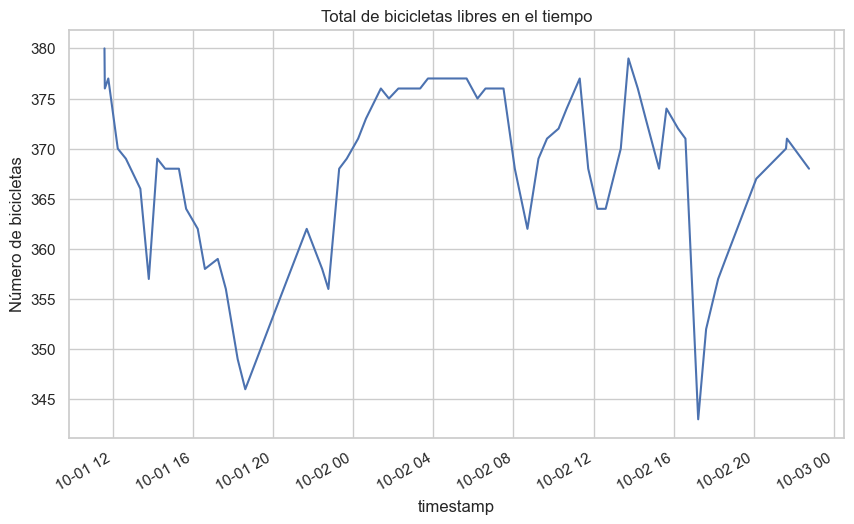

In [74]:
# ================================================
# 9. Series temporales
# ================================================
total_bikes = df.groupby("timestamp")["bicis_libres"].sum()
total_bikes.plot(title="Total de bicicletas libres en el tiempo")
plt.ylabel("Número de bicicletas")
plt.show()



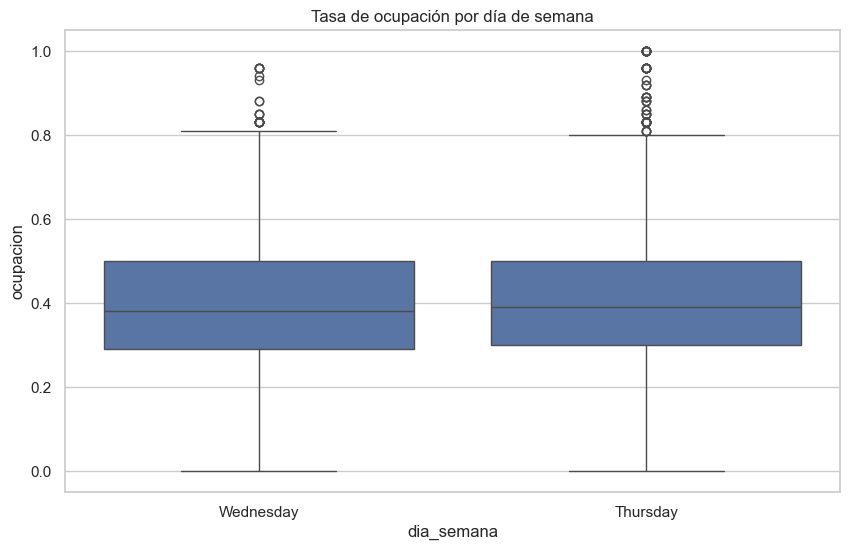

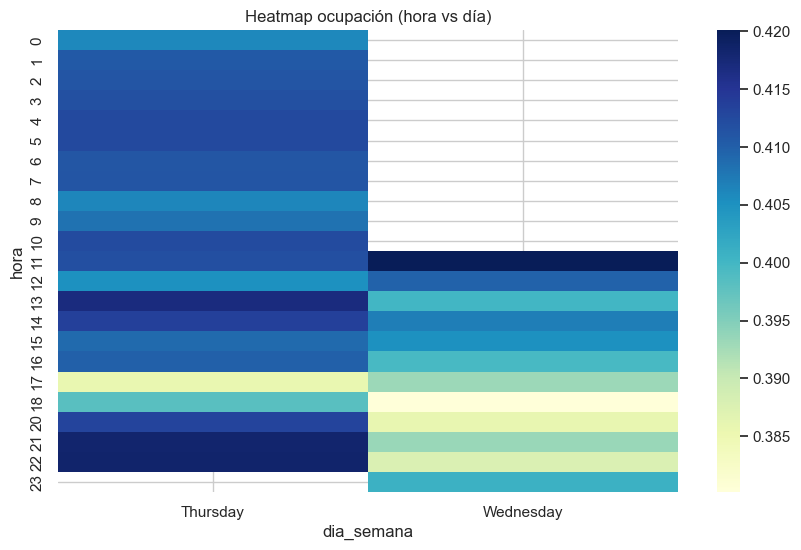

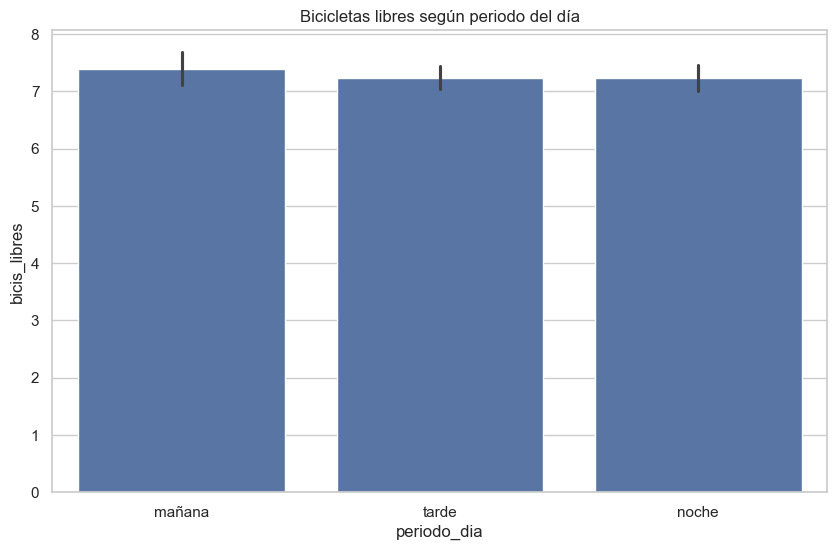

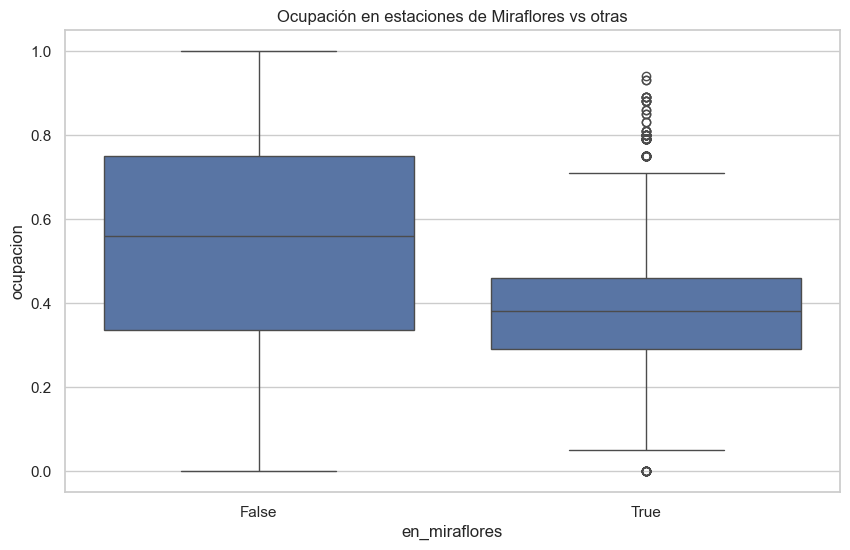

In [75]:

# ================================================
# 10. Distribuciones
# ================================================
# Evitar problemas si hay pocos días
# Boxplot por día de semana
if df["dia_semana"].nunique() > 1:
    sns.boxplot(x="dia_semana", y="ocupacion", data=df)
    plt.title("Tasa de ocupación por día de semana")
    plt.show()

# Heatmap hora vs día
pivot = df.pivot_table(index="hora", columns="dia_semana", values="ocupacion", aggfunc="mean")
if not pivot.empty:
    sns.heatmap(pivot, cmap="YlGnBu")
    plt.title("Heatmap ocupación (hora vs día)")
    plt.show()

# Bicicletas según clima (solo si hay datos útiles)
if df["clima_general"].nunique() > 1:
    sns.boxplot(x="clima_general", y="bicis_libres", data=df)
    plt.title("Bicicletas libres según clima")
    plt.xticks(rotation=45)
    plt.show()

# Periodo del día
sns.barplot(x="periodo_dia", y="bicis_libres", data=df, estimator=np.mean)
plt.title("Bicicletas libres según periodo del día")
plt.show()

# Miraflores vs resto
sns.boxplot(x="en_miraflores", y="ocupacion", data=df)
plt.title("Ocupación en estaciones de Miraflores vs otras")
plt.show()




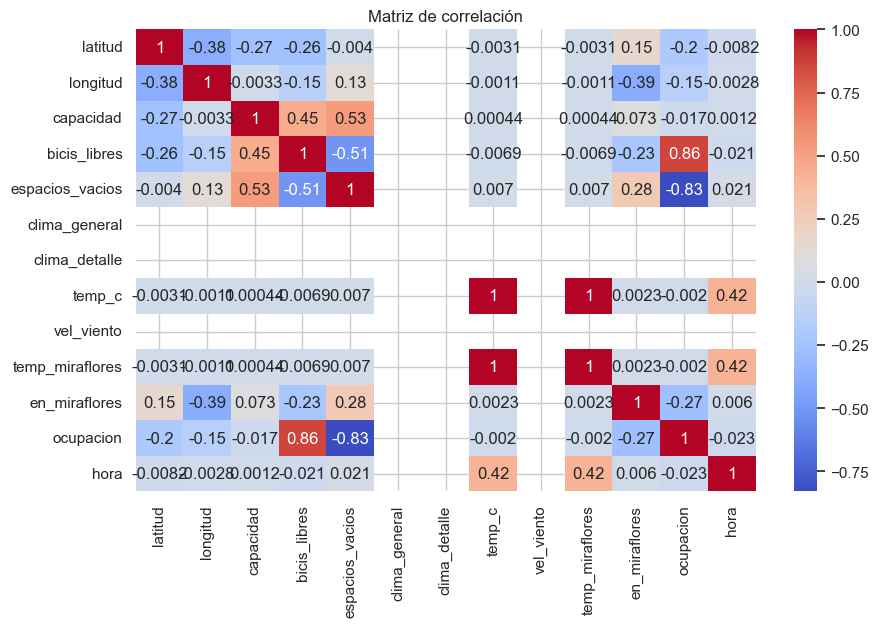

In [76]:


# ================================================
# 12. Matriz de correlación
# ================================================
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.title("Matriz de correlación")
plt.show()


